In [90]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [92]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [94]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [6]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Trend Following Signal

In [13]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [15]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [17]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [19]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                           donchian_signal_weight, ma_crossover_signal_weight,
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )

    ## Calculate Trend Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left') 

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                            donchian_signal_weight, ma_crossover_signal_weight, 
                                            long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:

        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight, 
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [21]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, 
                                                                long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, rolling_sharpe_window=50,
                                                                cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## ADX Filter with Macro Regime

In [24]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_adx_regime(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                                       donchian_signal_weight, ma_crossover_signal_weight, 
                                                                       adx_period=14, adx_signal_threshold=25, adx_cap=50, adx_floor=15, macro_mavg_window=200, macro_exponential_flag=True,
                                                                       moving_avg_type='exponential', price_or_returns_calc='price',
                                                                       long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )

    ## Calculate Trend Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    # Macro Trend Signal
    t_1_close_col = f'{ticker}_t_1_close'
    df_trend[t_1_close_col] = df_trend[f'{ticker}_close'].shift(1)
    simple_mavg_signal_col = f'{ticker}_simple_macro_{macro_mavg_window}d_signal'
    exp_mavg_signal_col = f'{ticker}_exp_macro_{macro_mavg_window}d_signal'
    df_trend[simple_mavg_signal_col] = df_trend[t_1_close_col].rolling(window=macro_mavg_window).mean()
    df_trend[exp_mavg_signal_col] = df_trend[t_1_close_col].ewm(span=macro_mavg_window).mean()
    # Price vs 100-EMA scaler (faster than 200-EMA)
    df_trend['px_vs_ema'] = df_trend[t_1_close_col] / df_trend[f'{ticker}_exp_macro_{macro_mavg_window}d_signal']
    df_trend['macro_scaler'] = np.clip((df_trend['px_vs_ema'] - 0.98) / 0.04, 0, 1)   # 0→1 between 0.98×EMA and 1.02×EMA

    ## Add ADX Signal
    strength_factor_col = f'{ticker}_adx_strength_factor'
    df_adx = calculate_average_directional_index(start_date, end_date, ticker=ticker, adx_period=adx_period)
    df_trend = pd.merge(df_trend, df_adx, left_index=True, right_index=True, how='left')
    df_trend[f'{ticker}_adx_scaler'] = np.clip((df_trend[f'{ticker}_avg_dir_ind'] - adx_floor) / (adx_cap - adx_floor), 0.0, 1.0)
    # if macro_exponential_flag:
    #     regime_filter_cond = (df_trend[f'{ticker}_avg_dir_ind'] > adx_signal_threshold) & (df_trend[f'{ticker}_t_1_close'] > df_trend[exp_mavg_signal_col])
    # else:
    #     regime_filter_cond = (df_trend[f'{ticker}_avg_dir_ind'] > adx_signal_threshold) & (df_trend[f'{ticker}_t_1_close'] > df_trend[simple_mavg_signal_col])
    regime_scaler = np.maximum(df_trend[f'{ticker}_adx_scaler'], df_trend['macro_scaler'])      # keep exposure if *either* looks healthy
    df_trend[strength_factor_col] = regime_scaler
    # df_trend[strength_factor_col] = np.where(regime_filter_cond, df_trend[f'{ticker}_adx_scaler'], 0)
    # df_trend[strength_factor_col] = np.where(regime_filter_cond, 1, 0)

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col]) * df_trend[strength_factor_col]

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    # k = 1
    # Dead Band under abs(0.03)
    # dead_band_cond = (np.abs(df_trend[final_weighted_additive_signal_col]) < 0.03)
    # df_trend.loc[dead_band_cond, final_weighted_additive_signal_col] = 0
    df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[strength_factor_col]
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend


def get_trend_donchian_signal_for_portfolio_adx_regime(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                  donchian_signal_weight, ma_crossover_signal_weight, 
                                                  adx_period=14, adx_signal_threshold=25, adx_cap=50, adx_floor=15, macro_mavg_window=200, macro_exponential_flag=True,
                                                  long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:

        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_adx_regime(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_adx_regime(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight, 
                adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
                macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag,
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, f'{ticker}_adx_scaler', 'macro_scaler',
                      f'{ticker}_adx_strength_factor', final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [26]:
def apply_target_volatility_position_sizing_continuous_strategy_adx_regime(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                       mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, 
                                                                       adx_period=14, adx_signal_threshold=25, adx_cap=50, adx_floor=15,
                                                                       macro_mavg_window=200, macro_exponential_flag=True,
                                                                       long_only=False, initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                       rolling_atr_window=20, atr_multiplier=0.5,
                                                                       transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                       use_coinbase_data=True, rolling_sharpe_window=50,
                                                                       cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                       annual_trading_days=365, use_specific_start_date=False,
                                                                       signal_start_date=None):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_adx_regime(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                             slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                             donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                             adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
                                                              macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag,
                                                             long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Rolling R Squared

### 📘 Pearson Correlation Coefficient Formula

The Pearson correlation coefficient \( r \) is given by:

$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
         {\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

Where:

- \( x_i, y_i \) are individual data points  
- \( \bar{x}, \bar{y} \) are the sample means of \( x \) and \( y \)  
- \( n \) is the number of observations


### 📘 Simplified Pearson Correlation Formula (Using Raw Sums)

The Pearson correlation coefficient \( r \) can also be written as:

$$
r = \frac{n \sum x_i y_i - \sum x_i \sum y_i}
         {\sqrt{n \sum x_i^2 - (\sum x_i)^2} \cdot \sqrt{n \sum y_i^2 - (\sum y_i)^2}}
$$

Where:

- \( x_i, y_i \) are the data values  
- \( n \) is the number of observations  
- \( \sum x_i y_i \) is the sum of the elementwise products  
- \( \sum x_i \), \( \sum y_i \) are the sums of each series  
- \( \sum x_i^2 \), \( \sum y_i^2 \) are the sums of squares


In [31]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
    y_sum = y.rolling(r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
    y_sqr = (y**2).rolling(r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

    ## Calculate the R squared
    n = r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above 0.8 are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    return df

In [33]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r2(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                                           donchian_signal_weight, ma_crossover_signal_weight, r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                                           long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )

    ## Calculate Trend Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [t_1_close_col, f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left') 

    ## Calculate the Rolling R-Squared
    df_trend = calculate_rolling_r2(df_trend, ticker=ticker, t_1_close_price_col=f't_1_close', r2_window=r2_window,
                                   lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit)

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile

    ## Applying Rolling R Squared Filter
    df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_rolling_r_sqr']
    
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio_with_rolling_r2(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                            donchian_signal_weight, ma_crossover_signal_weight,
                                                            r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                            long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:

        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        rolling_r_sqr_col = f'{ticker}_rolling_r_sqr'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r2(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r2(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight,
                r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col, rolling_r_sqr_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [249]:
# Below we calculate the number of risk units deployed per ticker per day
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal_continuous_rolling_r2(df, ticker_list, volatility_window, annual_trading_days=365):

    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        trend_signal_col = f'{ticker}_final_signal'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'

        ## Calculate Position Volatility Adjusted Trend Signal
        df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}_t_1_close')
        df[annualized_volatility_col] = (df[f'{ticker}_t_1_close_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        trend_cols = [f'{ticker}_close', f'{ticker}_open', f'{ticker}_t_1_close', f'{ticker}_t_1_close_pct_returns',
                      trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col, rolling_r2_col,
                      trend_signal_col, final_weighted_additive_signal_col, annualized_volatility_col,
                      vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    return df_signal

In [37]:
def apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                           mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, 
                                                                           r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                           long_only=False, initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                           rolling_atr_window=20, atr_multiplier=0.5,
                                                                           transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                           use_coinbase_data=True, rolling_sharpe_window=50,
                                                                           cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                           annual_trading_days=365, use_specific_start_date=False,
                                                                           signal_start_date=None):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r2(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                       r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                       long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal_continuous_rolling_r2(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Testing Signal

### Original Signal without Regime Awareness

In [41]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']#,'ETH-USD','SOL-USD']#,'DOGE-USD','LTC-USD','CRO-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.8
donchian_signal_weight = 0.2

In [31]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
df_final_with_smoothing_and_stretching_act_2_atr = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [32]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_2_atr, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7230140311091127,
 'annualized_sharpe_ratio': 1.3806675417487349,
 'calmar_ratio': 1.830991289035035,
 'annualized_std_dev': 0.8422482168650917,
 'max_drawdown': -0.39487573503976303,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.28780680918448137,
 't_statistic': 3.935411578481463,
 'p_value': 8.529696488330034e-05,
 'trade_count': 423.0}

In [259]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
ticker_list_eth = ['ETH-USD']
df_final_with_smoothing_and_stretching_act_2_atr_eth = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [260]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_2_atr_eth, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.8177675771277289,
 'annualized_sharpe_ratio': 1.3578744342165352,
 'calmar_ratio': 1.4108307047035467,
 'annualized_std_dev': 0.8801603976391312,
 'max_drawdown': -0.5796355114765975,
 'max_drawdown_duration': Timedelta('528 days 00:00:00'),
 'hit_rate': 0.2645324347093513,
 't_statistic': 3.715547104336425,
 'p_value': 0.00020744805923033564,
 'trade_count': 544.0}

In [267]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
ticker_list_sol = ['SOL-USD']
df_final_with_smoothing_and_stretching_act_2_atr_sol = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [269]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_2_atr_sol, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': -0.054342446681070466,
 'annualized_sharpe_ratio': 0.02239060359370685,
 'calmar_ratio': -0.07459518499419338,
 'annualized_std_dev': 0.875156839151407,
 'max_drawdown': -0.7284980483029914,
 'max_drawdown_duration': Timedelta('419 days 00:00:00'),
 'hit_rate': 0.22180451127819548,
 't_statistic': 0.14979792767119793,
 'p_value': 0.8809809234192717,
 'trade_count': 113.0}

### Signal with ADX Filter and Long Term Price Movement

In [56]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [57]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5829563167597849,
 'annualized_sharpe_ratio': 1.1943902970170968,
 'calmar_ratio': 1.5925970167387324,
 'annualized_std_dev': 0.8346475970106126,
 'max_drawdown': -0.366041321585258,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.27157561361836896,
 't_statistic': 3.45088360463331,
 'p_value': 0.0005679321589374999,
 'trade_count': 418.0}

In [62]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_binary = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [64]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_binary, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5829563167597835,
 'annualized_sharpe_ratio': 1.1943902970170954,
 'calmar_ratio': 1.5925970167387262,
 'annualized_std_dev': 0.8346475970106123,
 'max_drawdown': -0.3660413215852586,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.27157561361836896,
 't_statistic': 3.4508836046333053,
 'p_value': 0.0005679321589375083,
 'trade_count': 418.0}

In [97]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 200
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [98]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5829563167597849,
 'annualized_sharpe_ratio': 1.1943902970170968,
 'calmar_ratio': 1.5925970167387324,
 'annualized_std_dev': 0.8346475970106126,
 'max_drawdown': -0.366041321585258,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.27157561361836896,
 't_statistic': 3.45088360463331,
 'p_value': 0.0005679321589374999,
 'trade_count': 418.0}

In [99]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 100
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_100d_exp_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [100]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_100d_exp_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5176010746042008,
 'annualized_sharpe_ratio': 1.0960206590278718,
 'calmar_ratio': 1.2481521864169962,
 'annualized_std_dev': 0.8403913870122255,
 'max_drawdown': -0.41469388127264395,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.26247030878859856,
 't_statistic': 3.1936162532743895,
 'p_value': 0.0014223215864040742,
 'trade_count': 423.0}

In [103]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 80
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_80d_exp_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [106]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_80d_exp_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5248349055145995,
 'annualized_sharpe_ratio': 1.1167805575801935,
 'calmar_ratio': 1.3081525150625464,
 'annualized_std_dev': 0.8450189662504339,
 'max_drawdown': -0.4012031467825491,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.2596991290577989,
 't_statistic': 3.252380349493628,
 'p_value': 0.0011594989495697186,
 'trade_count': 413.0}

In [107]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 50
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_50d_exp_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [108]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_50d_exp_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.42866532929981305,
 'annualized_sharpe_ratio': 0.98380354237332,
 'calmar_ratio': 0.7988126274850773,
 'annualized_std_dev': 0.8180161759110236,
 'max_drawdown': -0.5366281334953246,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.23950910530482977,
 't_statistic': 2.9176715155436708,
 'p_value': 0.003557702787076655,
 'trade_count': 401.0}

In [37]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 200
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_vs_price_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_adx_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [38]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_200d_exp_vs_price_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7230140311091138,
 'annualized_sharpe_ratio': 1.3806675417487357,
 'calmar_ratio': 1.8309912890350388,
 'annualized_std_dev': 0.8422482168650919,
 'max_drawdown': -0.3948757350397628,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.28780680918448137,
 't_statistic': 3.935411578481465,
 'p_value': 8.529696488329946e-05,
 'trade_count': 423.0}

In [39]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 100
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_100d_exp_vs_price_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_adx_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [40]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_100d_exp_vs_price_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7230140311091138,
 'annualized_sharpe_ratio': 1.3806675417487364,
 'calmar_ratio': 1.8309912890350384,
 'annualized_std_dev': 0.8422482168650919,
 'max_drawdown': -0.3948757350397629,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.28780680918448137,
 't_statistic': 3.935411578481467,
 'p_value': 8.529696488329882e-05,
 'trade_count': 423.0}

In [41]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
macro_mavg_window = 80
macro_exponential_flag = True
df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_80d_exp_vs_price_adx_scaler = apply_target_volatility_position_sizing_continuous_strategy_adx_regime(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,
    macro_mavg_window=macro_mavg_window, macro_exponential_flag=macro_exponential_flag, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [42]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_with_adx_15_12_45_80d_exp_vs_price_adx_scaler, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7230140311091138,
 'annualized_sharpe_ratio': 1.3806675417487362,
 'calmar_ratio': 1.8309912890350384,
 'annualized_std_dev': 0.8422482168650919,
 'max_drawdown': -0.3948757350397629,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.28780680918448137,
 't_statistic': 3.935411578481468,
 'p_value': 8.529696488329832e-05,
 'trade_count': 423.0}

### Signal with Rolling R Squared

In [189]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.2
upper_r_sqr_limit = 0.8
r2_window = 30
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [191]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.4947597310528904,
 'annualized_sharpe_ratio': 1.1073211167195978,
 'calmar_ratio': 1.132954565399038,
 'annualized_std_dev': 0.8239161097194514,
 'max_drawdown': -0.43669865161682897,
 'max_drawdown_duration': Timedelta('512 days 00:00:00'),
 'hit_rate': 0.2288202692003167,
 't_statistic': 3.246278509538415,
 'p_value': 0.0011845350589664693,
 'trade_count': 374.0}

In [345]:
ticker = ticker_list[0]
donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
trend_signal_col = f'{ticker}_final_signal'
final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
rolling_r2_col = f'{ticker}_rolling_r_sqr'
corr_cols = [donchian_continuous_signal_rank_col, trend_continuous_signal_rank_col, rolling_r2_col]

In [347]:
df_final_with_rolling_r2[corr_cols].corr()

,BTC-USD_donchian_continuous_signal_rank,BTC-USD_mavg_ribbon_rank,BTC-USD_rolling_r_sqr
BTC-USD_donchian_continuous_signal_rank,1.000000,0.322567,0.207934
BTC-USD_mavg_ribbon_rank,0.322567,1.000000,0.128542
BTC-USD_rolling_r_sqr,0.207934,0.128542,1.000000


In [199]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.3
upper_r_sqr_limit = 0.8
r2_window = 30
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [200]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5696416667334874,
 'annualized_sharpe_ratio': 1.279271999390454,
 'calmar_ratio': 1.7571715476076695,
 'annualized_std_dev': 0.8220818975383464,
 'max_drawdown': -0.32418102120366993,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.20625494853523357,
 't_statistic': 3.7160727588596414,
 'p_value': 0.00020673615211519715,
 'trade_count': 332.0}

In [349]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.8
r2_window = 30
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [351]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5779377256609031,
 'annualized_sharpe_ratio': 1.3336491510764255,
 'calmar_ratio': 1.904055665785083,
 'annualized_std_dev': 0.8442003106951449,
 'max_drawdown': -0.3035298473916239,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.18844022169437846,
 't_statistic': 3.8741263104051202,
 'p_value': 0.00010972945026882634,
 'trade_count': 299.0}

In [217]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.8
r2_window = 40
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [218]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.49839239787962875,
 'annualized_sharpe_ratio': 1.1512212075536894,
 'calmar_ratio': 1.386703458685373,
 'annualized_std_dev': 0.8497826754124815,
 'max_drawdown': -0.3594080585564532,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.19635787806809185,
 't_statistic': 3.3783974121024634,
 'p_value': 0.0007401577532239965,
 'trade_count': 312.0}

In [221]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.8
r2_window = 20
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [222]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5193244605336194,
 'annualized_sharpe_ratio': 1.2212885525705868,
 'calmar_ratio': 1.3463600919592709,
 'annualized_std_dev': 0.8339305721942313,
 'max_drawdown': -0.3857247876219207,
 'max_drawdown_duration': Timedelta('677 days 00:00:00'),
 'hit_rate': 0.18091844813935076,
 't_statistic': 3.5767192783837185,
 'p_value': 0.00035447142114320205,
 'trade_count': 322.0}

In [225]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.5
upper_r_sqr_limit = 0.8
r2_window = 30
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [226]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.539625192632603,
 'annualized_sharpe_ratio': 1.2964438988687463,
 'calmar_ratio': 1.8538496393797517,
 'annualized_std_dev': 0.8533891275639734,
 'max_drawdown': -0.2910835815212862,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.17220902612826602,
 't_statistic': 3.789232933778736,
 'p_value': 0.000154645660984086,
 'trade_count': 277.0}

In [229]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.9
r2_window = 30
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [230]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5779377256609035,
 'annualized_sharpe_ratio': 1.3336491510764261,
 'calmar_ratio': 1.904055665785086,
 'annualized_std_dev': 0.8442003106951446,
 'max_drawdown': -0.30352984739162364,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.18844022169437846,
 't_statistic': 3.874126310405124,
 'p_value': 0.00010972945026882454,
 'trade_count': 299.0}

In [237]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.6
r2_window = 30
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [238]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5779377256609042,
 'annualized_sharpe_ratio': 1.3336491510764266,
 'calmar_ratio': 1.9040556657850876,
 'annualized_std_dev': 0.8442003106951446,
 'max_drawdown': -0.30352984739162375,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.18844022169437846,
 't_statistic': 3.8741263104051225,
 'p_value': 0.00010972945026882516,
 'trade_count': 299.0}

In [241]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.25
upper_r_sqr_limit = 0.8
r2_window = 40
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [242]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.513571797123834,
 'annualized_sharpe_ratio': 1.1471238756421003,
 'calmar_ratio': 1.3299118198815552,
 'annualized_std_dev': 0.8416549860764413,
 'max_drawdown': -0.3861698117470479,
 'max_drawdown_duration': Timedelta('509 days 00:00:00'),
 'hit_rate': 0.22288202692003167,
 't_statistic': 3.3538692026582737,
 'p_value': 0.0008086659991530675,
 'trade_count': 349.0}

In [217]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.8
r2_window = 30
## With Smoothing Function
df_final_with_rolling_r2 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [218]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5779377256609031,
 'annualized_sharpe_ratio': 1.3336491510764255,
 'calmar_ratio': 1.904055665785083,
 'annualized_std_dev': 0.8442003106951449,
 'max_drawdown': -0.3035298473916239,
 'max_drawdown_duration': Timedelta('721 days 00:00:00'),
 'hit_rate': 0.18844022169437846,
 't_statistic': 3.8741263104051202,
 'p_value': 0.00010972945026882634,
 'trade_count': 299.0}

In [227]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
## With Smoothing Function
df_final_with_rolling_r2_50_45_8 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [228]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2_50_45_8, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.48500110266629815,
 'annualized_sharpe_ratio': 1.148637529242552,
 'calmar_ratio': 1.2653528767272393,
 'annualized_std_dev': 0.8481789107242338,
 'max_drawdown': -0.383293160024044,
 'max_drawdown_duration': Timedelta('508 days 00:00:00'),
 'hit_rate': 0.1920031670625495,
 't_statistic': 3.381490968244965,
 'p_value': 0.0007319111230699469,
 'trade_count': 304.0}

In [235]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.35
upper_r_sqr_limit = 0.8
r2_window = 50
## With Smoothing Function
df_final_with_rolling_r2_50_35_8 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [237]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2_50_35_8, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5488192050637535,
 'annualized_sharpe_ratio': 1.2278077496327109,
 'calmar_ratio': 1.4682962146170244,
 'annualized_std_dev': 0.856029923271007,
 'max_drawdown': -0.3737796226675569,
 'max_drawdown_duration': Timedelta('626 days 00:00:00'),
 'hit_rate': 0.2082343626286619,
 't_statistic': 3.5744430256277906,
 'p_value': 0.0003575535214137087,
 'trade_count': 330.0}

In [245]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.8
r2_window = 30
ticker_list_eth = ['ETH-USD']
df_final_with_rolling_r2_eth = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [249]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2_eth, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5279638849123056,
 'annualized_sharpe_ratio': 1.1351559924383412,
 'calmar_ratio': 1.045541709315071,
 'annualized_std_dev': 0.8726742725951477,
 'max_drawdown': -0.5049668322253467,
 'max_drawdown_duration': Timedelta('761 days 00:00:00'),
 'hit_rate': 0.16343723673125526,
 't_statistic': 3.2061783299585147,
 'p_value': 0.0013629850385436376,
 'trade_count': 372.0}

In [239]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.35
upper_r_sqr_limit = 0.8
r2_window = 50
ticker_list_eth = ['ETH-USD']
df_final_with_rolling_r2_eth_50_35_8 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [240]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2_eth_50_35_8, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.4713933523875664,
 'annualized_sharpe_ratio': 0.9956577927261485,
 'calmar_ratio': 0.7848227610434402,
 'annualized_std_dev': 0.8821859296745624,
 'max_drawdown': -0.6006366988654075,
 'max_drawdown_duration': Timedelta('1069 days 00:00:00'),
 'hit_rate': 0.1950294860994103,
 't_statistic': 2.827748638592116,
 'p_value': 0.004726980217138108,
 'trade_count': 419.0}

In [271]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.4
upper_r_sqr_limit = 0.8
r2_window = 30
ticker_list_sol = ['SOL-USD']
df_final_with_rolling_r2_sol = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [273]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2_sol, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.46808687053489506,
 'annualized_sharpe_ratio': 1.1354460820009873,
 'calmar_ratio': 1.2500236362317647,
 'annualized_std_dev': 0.8218686942766791,
 'max_drawdown': -0.37446241572355987,
 'max_drawdown_duration': Timedelta('419 days 00:00:00'),
 'hit_rate': 0.11654135338345864,
 't_statistic': 1.540243199239214,
 'p_value': 0.12409676538242638,
 'trade_count': 65.0}

In [243]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.35
upper_r_sqr_limit = 0.8
r2_window = 50
ticker_list_sol = ['SOL-USD']
df_final_with_rolling_r2_sol_50_35_8 = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [245]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_final_with_rolling_r2_sol_50_35_8, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': -0.07423109709619402,
 'annualized_sharpe_ratio': -0.2323437228047023,
 'calmar_ratio': -0.16391434183913048,
 'annualized_std_dev': 0.669002816776646,
 'max_drawdown': -0.45286517496465456,
 'max_drawdown_duration': Timedelta('419 days 00:00:00'),
 'hit_rate': 0.12969924812030076,
 't_statistic': -0.09697618719610578,
 'p_value': 0.9227818958527924,
 'trade_count': 75.0}

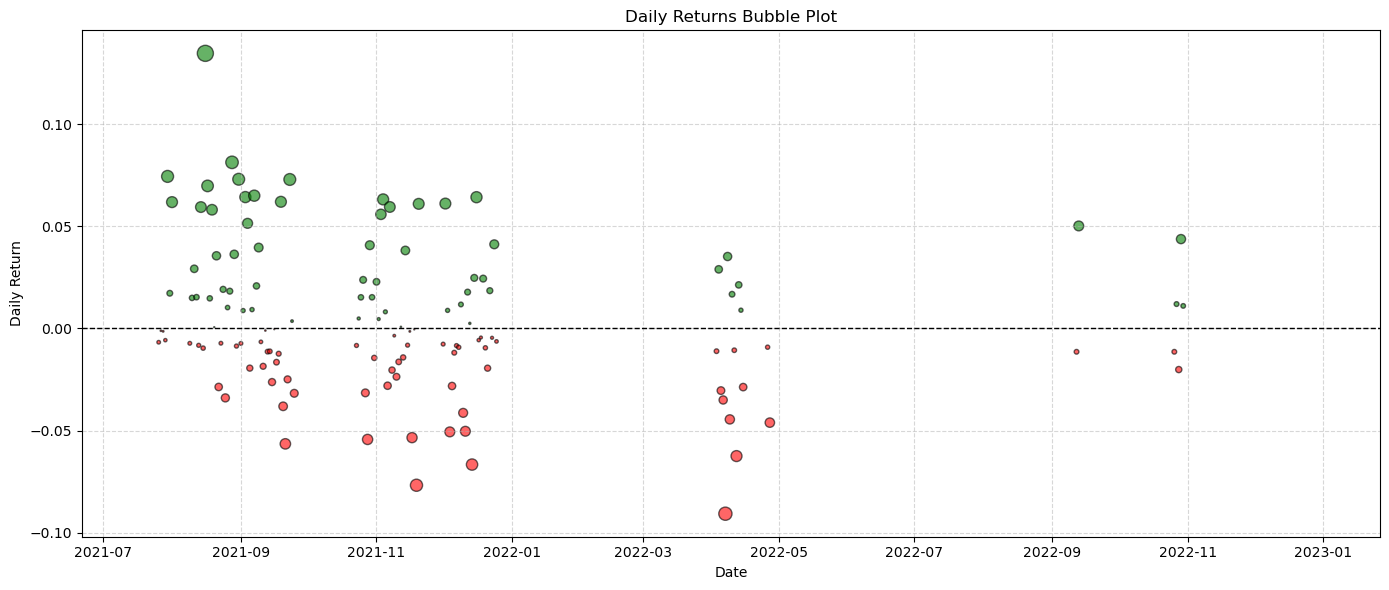

In [281]:
perf.plot_daily_returns_bubble(df_final_with_rolling_r2_sol, return_col='portfolio_daily_pct_returns')

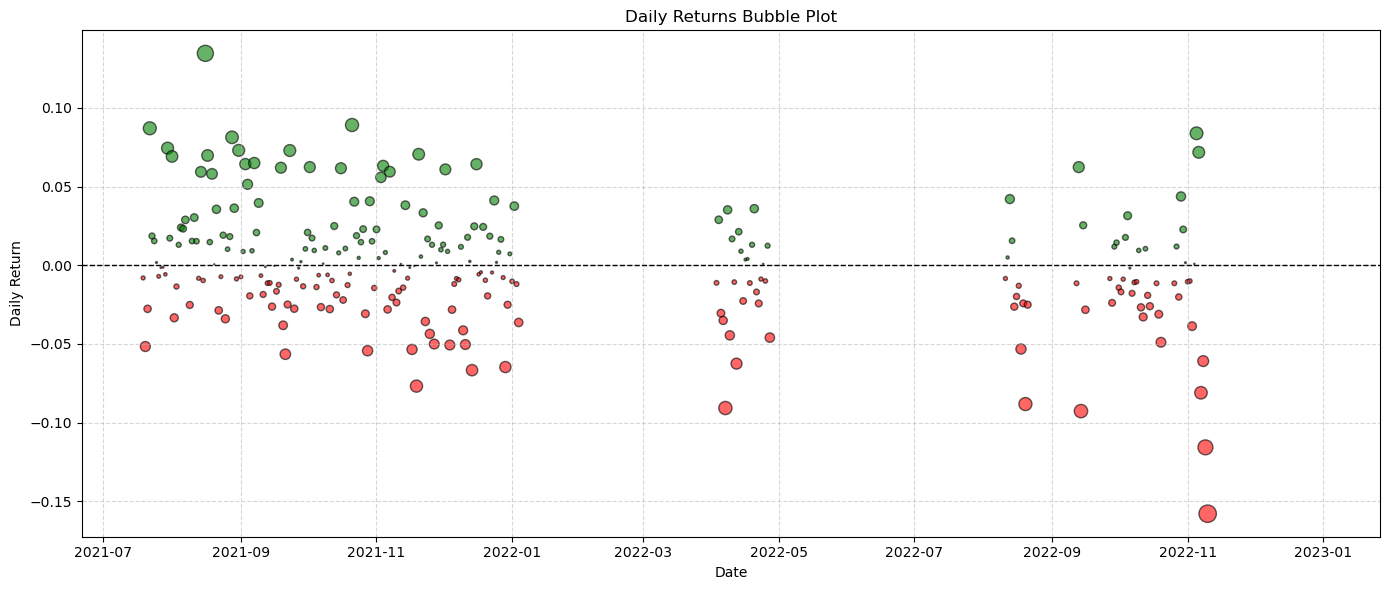

In [283]:
perf.plot_daily_returns_bubble(df_final_with_smoothing_and_stretching_act_2_atr_sol, return_col='portfolio_daily_pct_returns')

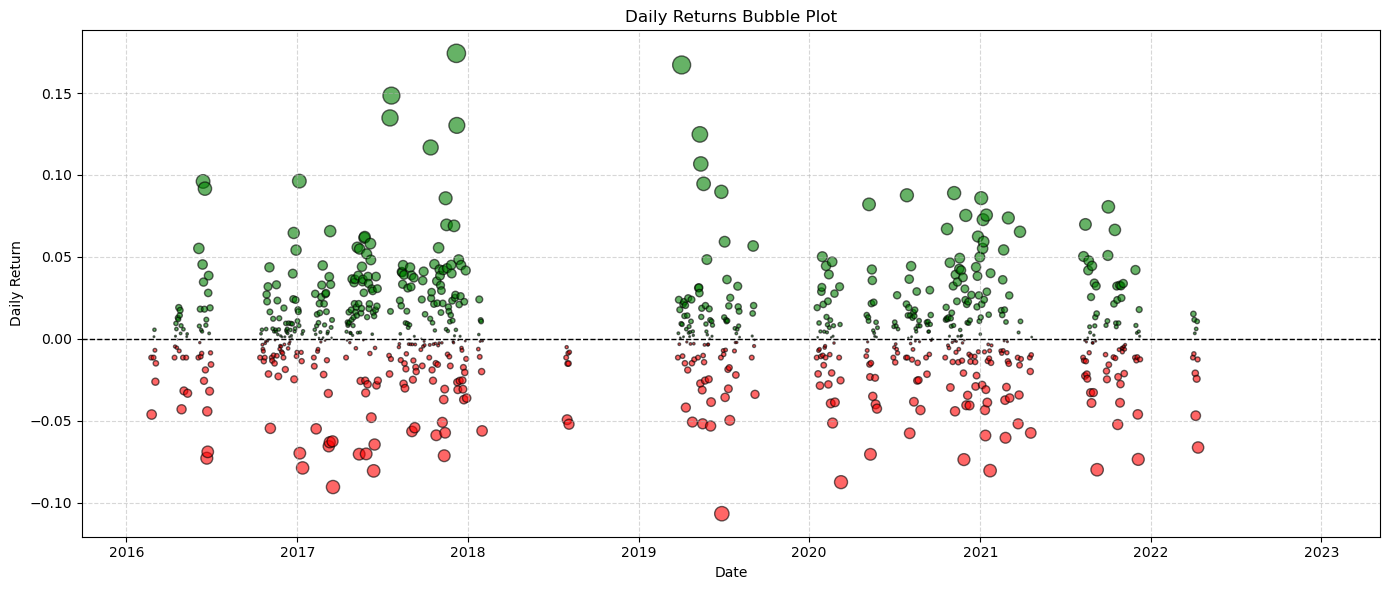

In [209]:
perf.plot_daily_returns_bubble(df_final_with_rolling_r2, return_col='portfolio_daily_pct_returns')

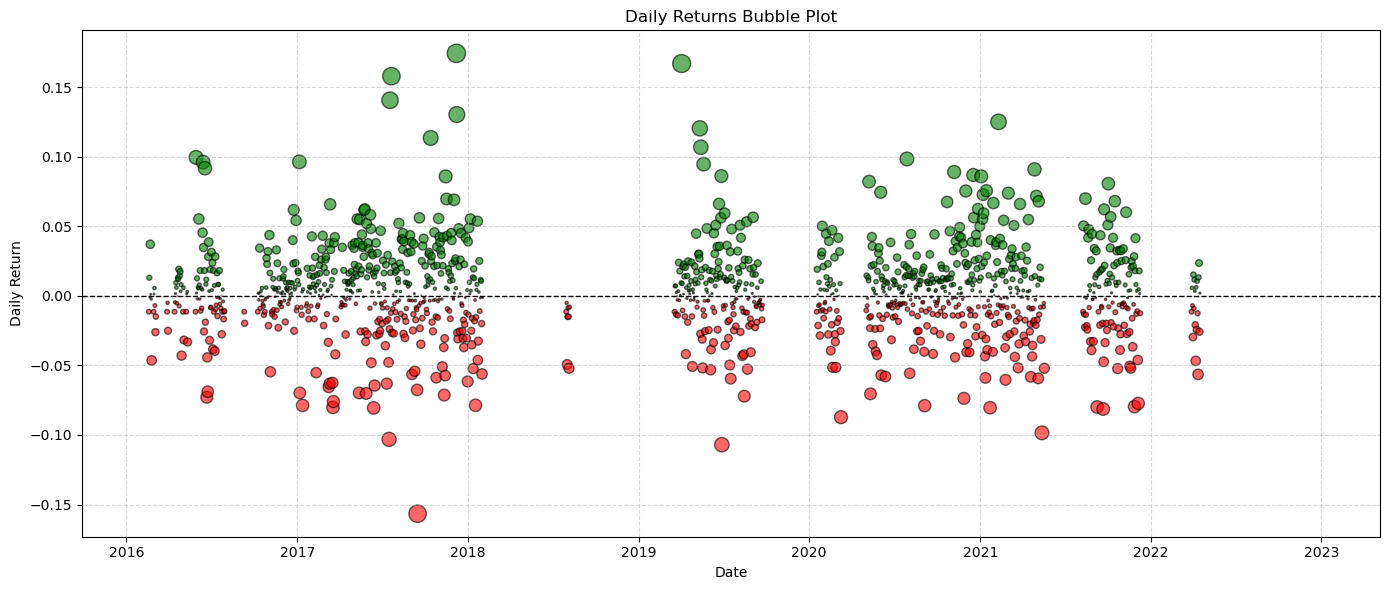

In [211]:
perf.plot_daily_returns_bubble(df_final_with_smoothing_and_stretching_act_2_atr, return_col='portfolio_daily_pct_returns')

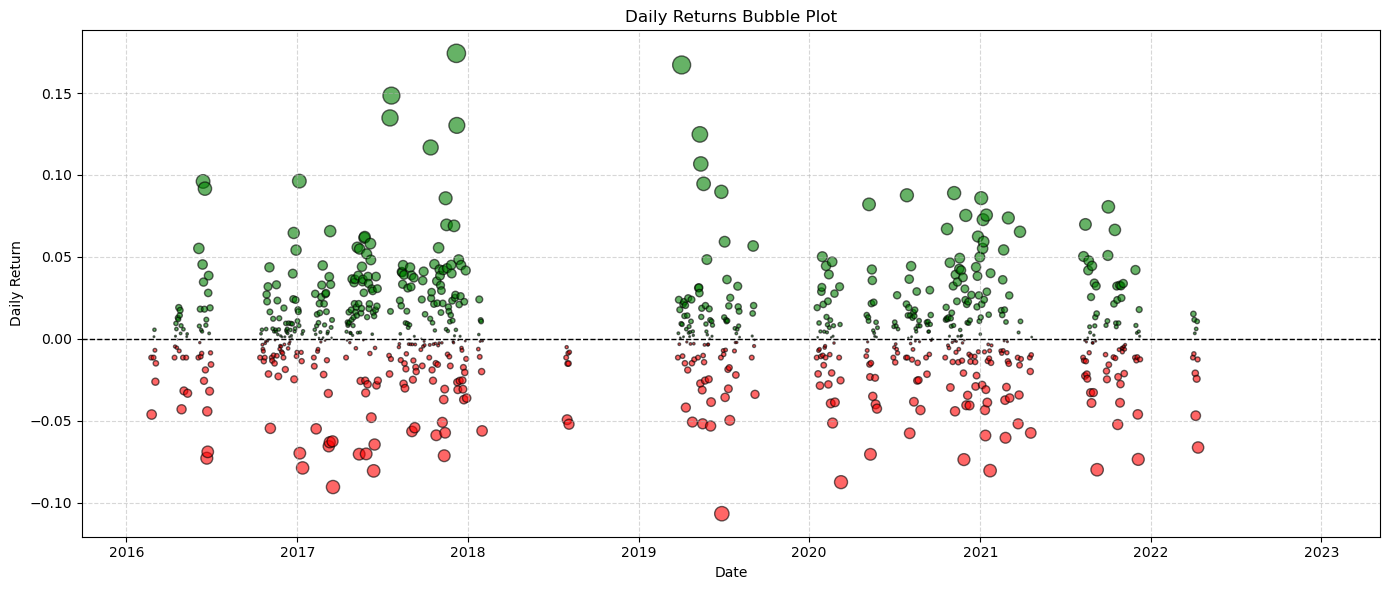

In [231]:
perf.plot_daily_returns_bubble(df_final_with_rolling_r2, return_col='portfolio_daily_pct_returns')

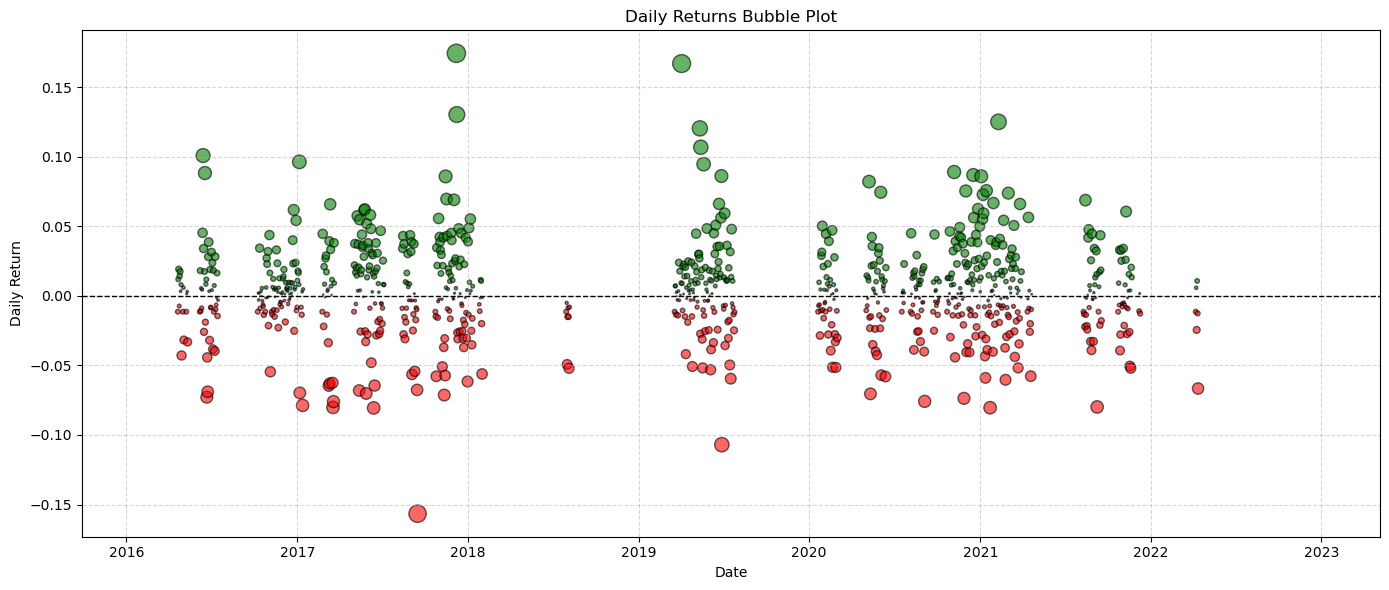

In [233]:
perf.plot_daily_returns_bubble(df_final_with_rolling_r2_50_45_8, return_col='portfolio_daily_pct_returns')

## Walk Forward Analysis of Rolling R Squared

In [43]:
import itertools

def generate_rolling_r_sqr_params():
    parameter_grid = {
        "r2_window": [20, 30, 40, 50],
        "lower_r_sqr_limit":     [0.25, 0.35, 0.45],
        "upper_r_sqr_limit":     [0.75, 0.80],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [144]:
def run_walk_forward_analysis_rolling_r_sqr(start_date, end_date, ticker='BTC-USD'):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    ticker_list = [ticker]
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'r2_window', 'lower_r_sqr_limit', 'upper_r_sqr_limit', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    IS_LEN = pd.DateOffset(years=3)
    OS_LEN = pd.DateOffset(years=1)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(start_date_is, end_date_is, start_date_os, end_date_os)
        if end_date_os > end_date:
            break
    
        for params in generate_rolling_r_sqr_params():
            print(params)
            r2_window = params['r2_window']
            lower_r_sqr_limit = params['lower_r_sqr_limit']
            upper_r_sqr_limit = params['upper_r_sqr_limit']
            df_is = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                volatility_window=volatility_window, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                annualized_target_volatility=annualized_target_volatility, annual_trading_days=annual_trading_days, 
                use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            df_os = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
                start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                volatility_window=volatility_window, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                annualized_target_volatility=annualized_target_volatility, annual_trading_days=annual_trading_days, 
                use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            performance_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                            passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            performance_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                            passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            row_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'r2_window': r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit,
                'annualized_return': performance_metrics_is['annualized_return'],
                'sharpe_ratio': performance_metrics_is['annualized_sharpe_ratio'],
                'calmar_ratio': performance_metrics_is['calmar_ratio'],
                'annualized_std_dev': performance_metrics_is['annualized_std_dev'],
                'max_drawdown': performance_metrics_is['max_drawdown'],
                'max_drawdown_duration': performance_metrics_is['max_drawdown_duration'],
                'hit_rate': performance_metrics_is['hit_rate'],
                't_statistic': performance_metrics_is['t_statistic'],
                'p_value': performance_metrics_is['p_value'],
                'trade_count': performance_metrics_is['trade_count']
            }
            row_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'r2_window': r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit,
                'annualized_return': performance_metrics_os['annualized_return'],
                'sharpe_ratio': performance_metrics_os['annualized_sharpe_ratio'],
                'calmar_ratio': performance_metrics_os['calmar_ratio'],
                'annualized_std_dev': performance_metrics_os['annualized_std_dev'],
                'max_drawdown': performance_metrics_os['max_drawdown'],
                'max_drawdown_duration': performance_metrics_os['max_drawdown_duration'],
                'hit_rate': performance_metrics_os['hit_rate'],
                't_statistic': performance_metrics_os['t_statistic'],
                'p_value': performance_metrics_os['p_value'],
                'trade_count': performance_metrics_os['trade_count']
            }
            df_performance = pd.concat([df_performance, pd.DataFrame([row_is])], ignore_index=True)
            df_performance = pd.concat([df_performance, pd.DataFrame([row_os])], ignore_index=True)
    
        start_date_is = (start_date_is + OS_LEN).date()

    return df_performance

In [77]:
df_performance_1 = run_walk_forward_analysis_rolling_r_sqr(start_date='2016-01-01', end_date='2019-12-31')

2016-01-01 2018-12-31 2019-01-01 2019-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [79]:
df_performance_1

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2016-01-01,2018-12-31,20,0.25,0.75,1.274145,2.157662,4.995137,0.832380,-0.255077,344 days,0.230986,3.897310,0.000103,169.0
1,out_sample,2019-01-01,2019-12-31,20,0.25,0.75,0.411251,0.924461,1.465878,0.880815,-0.280549,187 days,0.203593,0.999100,0.318472,56.0
2,in_sample,2016-01-01,2018-12-31,20,0.25,0.80,1.274145,2.157662,4.995137,0.832380,-0.255077,344 days,0.230986,3.897310,0.000103,169.0
3,out_sample,2019-01-01,2019-12-31,20,0.25,0.80,0.411251,0.924461,1.465878,0.880815,-0.280549,187 days,0.203593,0.999100,0.318472,56.0
4,in_sample,2016-01-01,2018-12-31,20,0.35,0.75,1.068952,1.958488,4.190744,0.856851,-0.255075,344 days,0.215023,3.562856,0.000383,157.0
5,out_sample,2019-01-01,2019-12-31,20,0.35,0.75,0.260571,0.649950,0.924997,0.953638,-0.281699,187 days,0.176647,0.737966,0.461055,48.0
6,in_sample,2016-01-01,2018-12-31,20,0.35,0.80,1.068952,1.958488,4.190744,0.856851,-0.255075,344 days,0.215023,3.562856,0.000383,157.0
7,out_sample,2019-01-01,2019-12-31,20,0.35,0.80,0.260571,0.649950,0.924997,0.953638,-0.281699,187 days,0.176647,0.737966,0.461055,48.0
8,in_sample,2016-01-01,2018-12-31,20,0.45,0.75,0.825208,1.685228,3.347234,0.863459,-0.246534,344 days,0.193427,3.105432,0.001950,142.0
9,out_sample,2019-01-01,2019-12-31,20,0.45,0.75,0.180243,0.490089,0.652989,0.957604,-0.276028,187 days,0.155689,0.589184,0.556138,46.0


In [81]:
df_performance_2 = run_walk_forward_analysis_rolling_r_sqr(start_date='2017-01-01', end_date='2020-12-31')

2017-01-01 2019-12-31 2020-01-01 2020-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [83]:
df_performance_3 = run_walk_forward_analysis_rolling_r_sqr(start_date='2018-01-01', end_date='2021-12-31')

2018-01-01 2020-12-31 2021-01-01 2021-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [96]:
df_performance_4 = run_walk_forward_analysis_rolling_r_sqr(start_date='2019-01-01', end_date='2022-12-31')

2019-01-01 2021-12-31 2022-01-01 2022-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [98]:
df_performance_4

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2019-01-01,2021-12-31,20,0.25,0.75,0.296851,0.733546,0.683746,0.806809,-0.434154,509 days,0.199061,1.466107,0.142914,176.0
1,out_sample,2022-01-01,2022-12-31,20,0.25,0.75,-0.366463,-1.506162,-0.851276,0.793867,-0.430487,276 days,0.137725,-1.287617,0.198774,34.0
2,in_sample,2019-01-01,2021-12-31,20,0.25,0.80,0.296851,0.733546,0.683746,0.806809,-0.434154,509 days,0.199061,1.466107,0.142914,176.0
3,out_sample,2022-01-01,2022-12-31,20,0.25,0.80,-0.366463,-1.506162,-0.851276,0.793867,-0.430487,276 days,0.137725,-1.287617,0.198774,34.0
4,in_sample,2019-01-01,2021-12-31,20,0.35,0.75,0.286198,0.721769,0.766296,0.814625,-0.373482,508 days,0.178404,1.452079,0.146774,168.0
5,out_sample,2022-01-01,2022-12-31,20,0.35,0.75,-0.292821,-1.219042,-0.794288,0.735282,-0.368658,276 days,0.122754,-1.005240,0.315511,34.0
6,in_sample,2019-01-01,2021-12-31,20,0.35,0.80,0.286198,0.721769,0.766296,0.814625,-0.373482,508 days,0.178404,1.452079,0.146774,168.0
7,out_sample,2022-01-01,2022-12-31,20,0.35,0.80,-0.292821,-1.219042,-0.794288,0.735282,-0.368658,276 days,0.122754,-1.005240,0.315511,34.0
8,in_sample,2019-01-01,2021-12-31,20,0.45,0.75,0.213620,0.587008,0.608456,0.812424,-0.351086,512 days,0.153991,1.240325,0.215128,138.0
9,out_sample,2022-01-01,2022-12-31,20,0.45,0.75,-0.279560,-1.286742,-0.965598,0.726057,-0.289520,276 days,0.104790,-1.055098,0.292145,28.0


In [100]:
list_dfs = [df_performance_1, df_performance_2, df_performance_3, df_performance_4]
df_performance = pd.concat(list_dfs, axis=0, ignore_index=True)

In [108]:
df_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/BTC-USD_Rolling_R_Squared_Walk_Forward_Results_2016-01-01_2022-12-31.pickle')

In [104]:
df_performance.sort_values(['r2_window','lower_r_sqr_limit','upper_r_sqr_limit','sampling_category'])

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2016-01-01,2018-12-31,20,0.25,0.75,1.274145,2.157662,4.995137,0.832380,-0.255077,344 days,0.230986,3.897310,0.000103,169.0
48,in_sample,2017-01-01,2019-12-31,20,0.25,0.75,1.268885,2.049152,3.747948,0.870502,-0.338555,475 days,0.225564,3.697934,0.000228,174.0
96,in_sample,2018-01-01,2020-12-31,20,0.25,0.75,0.320977,0.841131,0.982760,0.817090,-0.326608,497 days,0.189671,1.681113,0.093034,132.0
144,in_sample,2019-01-01,2021-12-31,20,0.25,0.75,0.296851,0.733546,0.683746,0.806809,-0.434154,509 days,0.199061,1.466107,0.142914,176.0
1,out_sample,2019-01-01,2019-12-31,20,0.25,0.75,0.411251,0.924461,1.465878,0.880815,-0.280549,187 days,0.203593,0.999100,0.318472,56.0
49,out_sample,2020-01-01,2020-12-31,20,0.25,0.75,0.386266,0.949869,1.284828,0.728397,-0.300636,278 days,0.220896,1.039618,0.299270,50.0
97,out_sample,2021-01-01,2021-12-31,20,0.25,0.75,-0.491854,-1.995658,-0.907239,0.669844,-0.542144,312 days,0.149701,-1.769655,0.077700,48.0
145,out_sample,2022-01-01,2022-12-31,20,0.25,0.75,-0.366463,-1.506162,-0.851276,0.793867,-0.430487,276 days,0.137725,-1.287617,0.198774,34.0
2,in_sample,2016-01-01,2018-12-31,20,0.25,0.80,1.274145,2.157662,4.995137,0.832380,-0.255077,344 days,0.230986,3.897310,0.000103,169.0
50,in_sample,2017-01-01,2019-12-31,20,0.25,0.80,1.268885,2.049152,3.747948,0.870502,-0.338555,475 days,0.225564,3.697934,0.000228,174.0


In [112]:
# Aggregate performance across the 4 OS segments
out_of_sample_cond = (df_performance['sampling_category'] == 'out_sample')
df_summary_btc = (
    df_performance[out_of_sample_cond]
    .groupby(["r2_window", "lower_r_sqr_limit", "upper_r_sqr_limit"])
    .agg(
        os_sharpe_mean   = ("sharpe_ratio",        "mean"),
        os_sharpe_median = ("sharpe_ratio",        "median"),
        os_ret_mean      = ("annualized_return",   "mean"),
        os_calmar_mean   = ("calmar_ratio",        "mean"),
        os_dd_mean       = ("max_drawdown",        "mean"),
        segments_held    = ("sharpe_ratio",        "count"),
    )
    .reset_index()
    .sort_values("os_sharpe_mean", ascending=False)
)

In [114]:
df_summary_btc

,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,os_sharpe_mean,os_sharpe_median,os_ret_mean,os_calmar_mean,os_dd_mean,segments_held
23,50,0.45,0.80,0.403887,1.056796,0.533546,3.811983,-0.198178,4
22,50,0.45,0.75,0.403887,1.056796,0.533546,3.811983,-0.198178,4
15,40,0.35,0.80,0.365164,0.883978,0.632517,5.037815,-0.223035,4
14,40,0.35,0.75,0.365164,0.883978,0.632517,5.037815,-0.223035,4
20,50,0.35,0.75,0.235270,0.927962,0.510423,3.928437,-0.242002,4
21,50,0.35,0.80,0.235270,0.927962,0.510423,3.928437,-0.242002,4
12,40,0.25,0.75,0.179957,0.678809,0.514245,4.062215,-0.252787,4
13,40,0.25,0.80,0.179957,0.678809,0.514245,4.062215,-0.252787,4
19,50,0.25,0.80,0.126643,0.816419,0.460387,3.400997,-0.268956,4
18,50,0.25,0.75,0.126643,0.816419,0.460387,3.400997,-0.268956,4


In [146]:
df_performance_1_eth = run_walk_forward_analysis_rolling_r_sqr(start_date='2017-01-01', end_date='2020-12-31', ticker='ETH-USD')

2017-01-01 2019-12-31 2020-01-01 2020-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [148]:
df_performance_2_eth = run_walk_forward_analysis_rolling_r_sqr(start_date='2018-01-01', end_date='2021-12-31', ticker='ETH-USD')

2018-01-01 2020-12-31 2021-01-01 2021-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [150]:
df_performance_3_eth = run_walk_forward_analysis_rolling_r_sqr(start_date='2019-01-01', end_date='2022-12-31', ticker='ETH-USD')

2019-01-01 2021-12-31 2022-01-01 2022-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [152]:
df_performance_4_eth = run_walk_forward_analysis_rolling_r_sqr(start_date='2020-01-01', end_date='2023-12-31', ticker='ETH-USD')

2020-01-01 2022-12-31 2023-01-01 2023-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [154]:
list_dfs = [df_performance_1_eth, df_performance_2_eth, df_performance_3_eth, df_performance_4_eth]
df_performance_eth = pd.concat(list_dfs, axis=0, ignore_index=True)

In [156]:
df_performance_eth.sort_values(['r2_window','lower_r_sqr_limit','upper_r_sqr_limit','sampling_category'])

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2017-01-01,2019-12-31,20,0.25,0.75,0.872632,1.488590,2.055047,0.906439,-0.424629,524 days,0.200188,2.723514,0.006565,225.0
48,in_sample,2018-01-01,2020-12-31,20,0.25,0.75,0.217300,0.575591,0.534376,0.810301,-0.406642,467 days,0.162441,1.200539,0.230197,171.0
96,in_sample,2019-01-01,2021-12-31,20,0.25,0.75,0.870376,1.553416,3.477249,0.800693,-0.250306,230 days,0.204695,2.847019,0.004498,221.0
144,in_sample,2020-01-01,2022-12-31,20,0.25,0.75,0.419485,0.922708,1.077290,0.788252,-0.389389,417 days,0.194366,1.773589,0.076417,223.0
1,out_sample,2020-01-01,2020-12-31,20,0.25,0.75,0.489065,1.057090,1.721134,0.743861,-0.284153,180 days,0.188060,1.127205,0.260465,66.0
49,out_sample,2021-01-01,2021-12-31,20,0.25,0.75,0.237988,0.586458,0.777432,0.830154,-0.306120,233 days,0.224551,0.661645,0.508657,82.0
97,out_sample,2022-01-01,2022-12-31,20,0.25,0.75,-0.573937,-2.219688,-1.020286,0.793626,-0.562526,271 days,0.170659,-1.998500,0.046475,50.0
145,out_sample,2023-01-01,2023-12-31,20,0.25,0.75,-0.032914,-0.173986,-0.162216,0.687878,-0.202901,258 days,0.134731,0.007483,0.994034,32.0
2,in_sample,2017-01-01,2019-12-31,20,0.25,0.80,0.872632,1.488590,2.055047,0.906439,-0.424629,524 days,0.200188,2.723514,0.006565,225.0
50,in_sample,2018-01-01,2020-12-31,20,0.25,0.80,0.217300,0.575591,0.534376,0.810301,-0.406642,467 days,0.162441,1.200539,0.230197,171.0


In [158]:
# Aggregate performance across the 4 OS segments
out_of_sample_cond_eth = (df_performance_eth['sampling_category'] == 'out_sample')
df_summary_eth = (
    df_performance_eth[out_of_sample_cond_eth]
    .groupby(["r2_window", "lower_r_sqr_limit", "upper_r_sqr_limit"])
    .agg(
        os_sharpe_mean   = ("sharpe_ratio",        "mean"),
        os_sharpe_median = ("sharpe_ratio",        "median"),
        os_ret_mean      = ("annualized_return",   "mean"),
        os_calmar_mean   = ("calmar_ratio",        "mean"),
        os_dd_mean       = ("max_drawdown",        "mean"),
        segments_held    = ("sharpe_ratio",        "count"),
    )
    .reset_index()
    .sort_values("os_sharpe_mean", ascending=False)
)

In [160]:
df_summary_eth

,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,os_sharpe_mean,os_sharpe_median,os_ret_mean,os_calmar_mean,os_dd_mean,segments_held
22,50,0.45,0.75,0.152994,0.749072,0.179997,1.148138,-0.228246,4
23,50,0.45,0.80,0.152994,0.749072,0.179997,1.148138,-0.228246,4
19,50,0.25,0.80,0.127215,0.782845,0.189429,1.315409,-0.271972,4
18,50,0.25,0.75,0.127215,0.782845,0.189429,1.315409,-0.271972,4
20,50,0.35,0.75,0.032552,0.740226,0.156223,1.183367,-0.263508,4
21,50,0.35,0.80,0.032552,0.740226,0.156223,1.183367,-0.263508,4
14,40,0.35,0.75,0.028108,0.632804,0.093426,0.736786,-0.277026,4
15,40,0.35,0.80,0.028108,0.632804,0.093426,0.736786,-0.277026,4
6,30,0.25,0.75,0.027974,0.530187,0.225661,1.307603,-0.312332,4
7,30,0.25,0.80,0.027974,0.530187,0.225661,1.307603,-0.312332,4


In [162]:
df_performance_eth.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/ETH-USD_Rolling_R_Squared_Walk_Forward_Results_2017-01-01_2023-12-31.pickle')

In [164]:
df_performance.sort_values(['r2_window','lower_r_sqr_limit','upper_r_sqr_limit','sampling_category'])

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2016-01-01,2018-12-31,20,0.25,0.75,1.274145,2.157662,4.995137,0.832380,-0.255077,344 days,0.230986,3.897310,0.000103,169.0
48,in_sample,2017-01-01,2019-12-31,20,0.25,0.75,1.268885,2.049152,3.747948,0.870502,-0.338555,475 days,0.225564,3.697934,0.000228,174.0
96,in_sample,2018-01-01,2020-12-31,20,0.25,0.75,0.320977,0.841131,0.982760,0.817090,-0.326608,497 days,0.189671,1.681113,0.093034,132.0
144,in_sample,2019-01-01,2021-12-31,20,0.25,0.75,0.296851,0.733546,0.683746,0.806809,-0.434154,509 days,0.199061,1.466107,0.142914,176.0
1,out_sample,2019-01-01,2019-12-31,20,0.25,0.75,0.411251,0.924461,1.465878,0.880815,-0.280549,187 days,0.203593,0.999100,0.318472,56.0
49,out_sample,2020-01-01,2020-12-31,20,0.25,0.75,0.386266,0.949869,1.284828,0.728397,-0.300636,278 days,0.220896,1.039618,0.299270,50.0
97,out_sample,2021-01-01,2021-12-31,20,0.25,0.75,-0.491854,-1.995658,-0.907239,0.669844,-0.542144,312 days,0.149701,-1.769655,0.077700,48.0
145,out_sample,2022-01-01,2022-12-31,20,0.25,0.75,-0.366463,-1.506162,-0.851276,0.793867,-0.430487,276 days,0.137725,-1.287617,0.198774,34.0
2,in_sample,2016-01-01,2018-12-31,20,0.25,0.80,1.274145,2.157662,4.995137,0.832380,-0.255077,344 days,0.230986,3.897310,0.000103,169.0
50,in_sample,2017-01-01,2019-12-31,20,0.25,0.80,1.268885,2.049152,3.747948,0.870502,-0.338555,475 days,0.225564,3.697934,0.000228,174.0


In [166]:
df_performance_eth.sort_values(['r2_window','lower_r_sqr_limit','upper_r_sqr_limit','sampling_category'])

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2017-01-01,2019-12-31,20,0.25,0.75,0.872632,1.488590,2.055047,0.906439,-0.424629,524 days,0.200188,2.723514,0.006565,225.0
48,in_sample,2018-01-01,2020-12-31,20,0.25,0.75,0.217300,0.575591,0.534376,0.810301,-0.406642,467 days,0.162441,1.200539,0.230197,171.0
96,in_sample,2019-01-01,2021-12-31,20,0.25,0.75,0.870376,1.553416,3.477249,0.800693,-0.250306,230 days,0.204695,2.847019,0.004498,221.0
144,in_sample,2020-01-01,2022-12-31,20,0.25,0.75,0.419485,0.922708,1.077290,0.788252,-0.389389,417 days,0.194366,1.773589,0.076417,223.0
1,out_sample,2020-01-01,2020-12-31,20,0.25,0.75,0.489065,1.057090,1.721134,0.743861,-0.284153,180 days,0.188060,1.127205,0.260465,66.0
49,out_sample,2021-01-01,2021-12-31,20,0.25,0.75,0.237988,0.586458,0.777432,0.830154,-0.306120,233 days,0.224551,0.661645,0.508657,82.0
97,out_sample,2022-01-01,2022-12-31,20,0.25,0.75,-0.573937,-2.219688,-1.020286,0.793626,-0.562526,271 days,0.170659,-1.998500,0.046475,50.0
145,out_sample,2023-01-01,2023-12-31,20,0.25,0.75,-0.032914,-0.173986,-0.162216,0.687878,-0.202901,258 days,0.134731,0.007483,0.994034,32.0
2,in_sample,2017-01-01,2019-12-31,20,0.25,0.80,0.872632,1.488590,2.055047,0.906439,-0.424629,524 days,0.200188,2.723514,0.006565,225.0
50,in_sample,2018-01-01,2020-12-31,20,0.25,0.80,0.217300,0.575591,0.534376,0.810301,-0.406642,467 days,0.162441,1.200539,0.230197,171.0


In [172]:
df_performance_1_sol = run_walk_forward_analysis_rolling_r_sqr(start_date='2021-01-01', end_date='2024-12-31', ticker='SOL-USD')

2021-01-01 2023-12-31 2024-01-01 2024-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 20, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.35, 'upper_r_sqr_limit': 0.8}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.75}
{'r2_window': 30, 'lower_r_sqr_limit': 0.45, 'upper_r_sqr_limit': 0.8}
{'r2_window': 40, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}
{'r2_window': 40, 'lower_r

In [174]:
df_performance_1_sol

,sampling_category,start_date,end_date,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,in_sample,2021-01-01,2023-12-31,20,0.25,0.75,0.509083,1.081352,0.885992,0.808725,-0.574591,773 days,0.172798,1.880623,0.060347,180.0
1,out_sample,2024-01-01,2024-12-31,20,0.25,0.75,-0.403923,-1.028891,-0.759323,0.785190,-0.531951,288 days,0.185075,-0.882057,0.378381,68.0
2,in_sample,2021-01-01,2023-12-31,20,0.25,0.80,0.509083,1.081352,0.885992,0.808725,-0.574591,773 days,0.172798,1.880623,0.060347,180.0
3,out_sample,2024-01-01,2024-12-31,20,0.25,0.80,-0.403923,-1.028891,-0.759323,0.785190,-0.531951,288 days,0.185075,-0.882057,0.378381,68.0
4,in_sample,2021-01-01,2023-12-31,20,0.35,0.75,0.601038,1.266994,1.334189,0.827681,-0.450489,738 days,0.154961,2.181183,0.029429,159.0
5,out_sample,2024-01-01,2024-12-31,20,0.35,0.75,-0.211376,-0.467741,-0.493674,0.806513,-0.428169,288 days,0.182090,-0.337406,0.736023,66.0
6,in_sample,2021-01-01,2023-12-31,20,0.35,0.80,0.601038,1.266994,1.334189,0.827681,-0.450489,738 days,0.154961,2.181183,0.029429,159.0
7,out_sample,2024-01-01,2024-12-31,20,0.35,0.80,-0.211376,-0.467741,-0.493674,0.806513,-0.428169,288 days,0.182090,-0.337406,0.736023,66.0
8,in_sample,2021-01-01,2023-12-31,20,0.45,0.75,0.701459,1.458062,1.989511,0.833449,-0.352579,691 days,0.140468,2.487438,0.013048,141.0
9,out_sample,2024-01-01,2024-12-31,20,0.45,0.75,-0.094922,-0.160641,-0.270344,0.816848,-0.351116,288 days,0.164179,-0.039438,0.968564,62.0


In [180]:
df_performance_2_sol = run_walk_forward_analysis_rolling_r_sqr(start_date='2022-01-01', end_date='2025-12-31', ticker='SOL-USD')

2022-01-01 2024-12-31 2025-01-01 2025-12-31
{'r2_window': 20, 'lower_r_sqr_limit': 0.25, 'upper_r_sqr_limit': 0.75}


2025-07-01 06:53:37 - coinbase.RESTClient - ERROR - HTTP Error: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"start must not be in the future","message":"start must not be in the future"}


HTTPError: 400 Client Error: Bad Request {"error":"INVALID_ARGUMENT","error_details":"start must not be in the future","message":"start must not be in the future"}

In [182]:
list_dfs = [df_performance_1_sol]#, df_performance_2_sol]
df_performance_sol = pd.concat(list_dfs, axis=0, ignore_index=True)

In [184]:
# Aggregate performance across the 4 OS segments
out_of_sample_cond_sol = (df_performance_sol['sampling_category'] == 'out_sample')
df_summary_sol = (
    df_performance_sol[out_of_sample_cond_sol]
    .groupby(["r2_window", "lower_r_sqr_limit", "upper_r_sqr_limit"])
    .agg(
        os_sharpe_mean   = ("sharpe_ratio",        "mean"),
        os_sharpe_median = ("sharpe_ratio",        "median"),
        os_ret_mean      = ("annualized_return",   "mean"),
        os_calmar_mean   = ("calmar_ratio",        "mean"),
        os_dd_mean       = ("max_drawdown",        "mean"),
        segments_held    = ("sharpe_ratio",        "count"),
    )
    .reset_index()
    .sort_values("os_sharpe_mean", ascending=False)
)

In [186]:
df_summary_sol

,r2_window,lower_r_sqr_limit,upper_r_sqr_limit,os_sharpe_mean,os_sharpe_median,os_ret_mean,os_calmar_mean,os_dd_mean,segments_held
22,50,0.45,0.75,0.248222,0.248222,0.065871,0.142317,-0.462850,1
23,50,0.45,0.80,0.248222,0.248222,0.065871,0.142317,-0.462850,1
8,30,0.35,0.75,-0.038377,-0.038377,-0.050088,-0.127303,-0.393455,1
9,30,0.35,0.80,-0.038377,-0.038377,-0.050088,-0.127303,-0.393455,1
10,30,0.45,0.75,-0.135458,-0.135458,-0.083205,-0.212252,-0.392013,1
11,30,0.45,0.80,-0.135458,-0.135458,-0.083205,-0.212252,-0.392013,1
4,20,0.45,0.75,-0.160641,-0.160641,-0.094922,-0.270344,-0.351116,1
5,20,0.45,0.80,-0.160641,-0.160641,-0.094922,-0.270344,-0.351116,1
20,50,0.35,0.75,-0.203681,-0.203681,-0.128869,-0.266756,-0.483095,1
21,50,0.35,0.80,-0.203681,-0.203681,-0.128869,-0.266756,-0.483095,1


In [188]:
df_performance_sol.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/SOL-USD_Rolling_R_Squared_Walk_Forward_Results_2021-01-01_2024-12-31.pickle')

### Doubling Transaction Costs with Rolling R Squared Window of 50, Lower R Sqr Limit of 0.45 and Upper R Sqr Limit of 0.8

In [199]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
ticker_list = ['BTC-USD']#,'ETH-USD','SOL-USD']#,'DOGE-USD','LTC-USD','CRO-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
# transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.8
donchian_signal_weight = 0.2

In [201]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
transaction_cost_est = 0.001
df_btc_rolling_r2_orig_t_cost = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [203]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
perf.calculate_risk_and_performance_metrics(df_btc_rolling_r2_orig_t_cost, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.48500110266629815,
 'annualized_sharpe_ratio': 1.148637529242552,
 'calmar_ratio': 1.2653528767272393,
 'annualized_std_dev': 0.8481789107242338,
 'max_drawdown': -0.383293160024044,
 'max_drawdown_duration': Timedelta('508 days 00:00:00'),
 'hit_rate': 0.1920031670625495,
 't_statistic': 3.381490968244965,
 'p_value': 0.0007319111230699469,
 'trade_count': 304.0}

In [209]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
transaction_cost_est = 0.005
df_btc_rolling_r2_double_t_cost = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [211]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.005
perf.calculate_risk_and_performance_metrics(df_btc_rolling_r2_double_t_cost, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.43808774323249855,
 'annualized_sharpe_ratio': 1.0549765578609658,
 'calmar_ratio': 1.128047207692114,
 'annualized_std_dev': 0.8561573163697461,
 'max_drawdown': -0.38835940574578237,
 'max_drawdown_duration': Timedelta('657 days 00:00:00'),
 'hit_rate': 0.19121140142517815,
 't_statistic': 3.133200067780218,
 'p_value': 0.0017489482746761845,
 'trade_count': 304.0}

In [207]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.0025
perf.calculate_risk_and_performance_metrics(df_btc_rolling_r2_double_t_cost, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.4672440642208846,
 'annualized_sharpe_ratio': 1.1134781347831635,
 'calmar_ratio': 1.2130032639165915,
 'annualized_std_dev': 0.8510993494262408,
 'max_drawdown': -0.38519604861756845,
 'max_drawdown_duration': Timedelta('657 days 00:00:00'),
 'hit_rate': 0.1916072842438638,
 't_statistic': 3.2883118414591754,
 'p_value': 0.0010217276428822783,
 'trade_count': 304.0}

In [260]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
transaction_cost_est = 0.001
os_start_date = pd.Timestamp('2023-01-01').date()
os_end_date = pd.Timestamp('2025-05-31').date()
df_btc_rolling_r2_os = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=os_start_date, end_date=os_end_date, ticker_list=['BTC-USD'], fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [262]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.001
perf.calculate_risk_and_performance_metrics(df_btc_rolling_r2_os, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.2645637028530068,
 'annualized_sharpe_ratio': 0.833294659544062,
 'calmar_ratio': 1.5558258749788667,
 'annualized_std_dev': 0.7445115042856982,
 'max_drawdown': -0.17004711588088253,
 'max_drawdown_duration': Timedelta('242 days 00:00:00'),
 'hit_rate': 0.16568742655699178,
 't_statistic': 1.5536510546953848,
 'p_value': 0.12063990670030766,
 'trade_count': 63.0}

In [271]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
ticker_list_eth = ['ETH-USD']
df_final_with_smoothing_and_stretching_act_2_atr_eth_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=os_start_date, end_date=os_end_date, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [272]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.001
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_2_atr_eth_os, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': -0.038658698218137166,
 'annualized_sharpe_ratio': -0.07463906975209908,
 'calmar_ratio': -0.10631644531911924,
 'annualized_std_dev': 0.7423337245205517,
 'max_drawdown': -0.3636191757737883,
 'max_drawdown_duration': Timedelta('445 days 00:00:00'),
 'hit_rate': 0.2444183313748531,
 't_statistic': 0.09723666063788661,
 'p_value': 0.922561377423481,
 'trade_count': 109.0}

In [266]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
transaction_cost_est = 0.001
os_start_date = pd.Timestamp('2023-01-01').date()
os_end_date = pd.Timestamp('2025-05-31').date()
df_rolling_r2_os_eth = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=os_start_date, end_date=os_end_date, ticker_list=['ETH-USD'], fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [273]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.001
perf.calculate_risk_and_performance_metrics(df_rolling_r2_os_eth, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': -0.006851964439129721,
 'annualized_sharpe_ratio': -0.05162073203308412,
 'calmar_ratio': -0.02238669124078991,
 'annualized_std_dev': 0.7679397536142696,
 'max_drawdown': -0.30607312020478605,
 'max_drawdown_duration': Timedelta('445 days 00:00:00'),
 'hit_rate': 0.13748531139835488,
 't_statistic': 0.1807766982305875,
 'p_value': 0.8565859469478686,
 'trade_count': 69.0}

In [277]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
ticker_list_sol = ['SOL-USD']
df_final_with_smoothing_and_stretching_act_2_atr_sol_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=os_start_date, end_date=os_end_date, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [279]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.001
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_2_atr_sol_os, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.23556098776426548,
 'annualized_sharpe_ratio': 0.5774394803761534,
 'calmar_ratio': 0.4797222712988367,
 'annualized_std_dev': 0.8149128923040451,
 'max_drawdown': -0.4910361720886747,
 'max_drawdown_duration': Timedelta('439 days 00:00:00'),
 'hit_rate': 0.24324324324324326,
 't_statistic': 1.0398367286800343,
 'p_value': 0.29871144681901335,
 'trade_count': 198.0}

In [281]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## Stop Loss = 2.0 * ATR
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
transaction_cost_est = 0.001
os_start_date = pd.Timestamp('2023-01-01').date()
os_end_date = pd.Timestamp('2025-05-31').date()
df_rolling_r2_os_sol = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
    start_date=os_start_date, end_date=os_end_date, ticker_list=['SOL-USD'], fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [283]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian with Rolling R Squared filter
## transaction_cost_est = 0.001
perf.calculate_risk_and_performance_metrics(df_rolling_r2_os_sol, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.3784642787217518,
 'annualized_sharpe_ratio': 0.8743090865648128,
 'calmar_ratio': 0.7719858688802884,
 'annualized_std_dev': 0.8221860933989671,
 'max_drawdown': -0.4902476767750786,
 'max_drawdown_duration': Timedelta('439 days 00:00:00'),
 'hit_rate': 0.17156286721504113,
 't_statistic': 1.5198807626089694,
 'p_value': 0.12891281452852418,
 'trade_count': 148.0}

## Adding Vol of Vol Filter

In [285]:
def generate_vol_of_vol_signal(df, ticker, vol_of_vol_window_1, vol_of_vol_window_2, vol_of_vol_z_score_window=252):
    
    df[f'{ticker}_realized_vol'] = df[f'{ticker}_t_1_close'].pct_change().rolling(vol_of_vol_window_1).std()
    df[f'{ticker}_vol_of_vol'] = df[f'{ticker}_realized_vol'].rolling(vol_of_vol_window_2).std()
    df[f'{ticker}_vol_of_vol_z_score'] = (df[f'{ticker}_vol_of_vol'] - df[f'{ticker}_vol_of_vol'].rolling(vol_of_vol_z_score_window).mean()) / df[f'{ticker}_vol_of_vol'].rolling(vol_of_vol_z_score_window).std()
    df[f'{ticker}_vol_of_vol_scaler'] = np.clip(1 - df[f'{ticker}_vol_of_vol_z_score'], 0, 1)

    return df

In [291]:
df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r2(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                       r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                       long_only=long_only, use_coinbase_data=use_coinbase_data)

In [295]:
df_trend = generate_vol_of_vol_signal(df_trend, ticker='BTC-USD', vol_of_vol_window_1=14, vol_of_vol_window_2=10, vol_of_vol_z_score_window=126)

KeyError: 'BTC-USD_t_1_close'

In [292]:
df_trend.head()

,BTC-USD_close,BTC-USD_open,BTC-USD_20_donchian_upper_band_price_t_2,BTC-USD_20_donchian_lower_band_price_t_2,BTC-USD_donchian_continuous_signal,BTC-USD_donchian_continuous_signal_rank,BTC-USD_mavg_ribbon_slope,BTC-USD_mavg_ribbon_rank,BTC-USD_final_weighted_additive_signal,BTC-USD_final_signal,BTC-USD_rolling_r_sqr
date,,,,,,,,,,,
2016-01-11,449.19,449.99,NaN,NaN,NaN,NaN,0.020986,-0.064586,NaN,NaN,NaN
2016-01-12,434.01,449.26,NaN,NaN,NaN,NaN,0.014258,-0.064978,NaN,NaN,NaN
2016-01-13,432.77,434.01,NaN,NaN,NaN,NaN,0.008104,-0.065371,NaN,NaN,NaN
2016-01-14,430.03,432.70,NaN,NaN,NaN,NaN,0.001598,-0.066353,NaN,NaN,NaN
2016-01-15,357.53,430.04,NaN,NaN,NaN,NaN,-0.041454,-0.070377,NaN,NaN,NaN


In [ ]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r2_vol_of_vol(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                                                      donchian_signal_weight, ma_crossover_signal_weight, r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                                      moving_avg_type='exponential', price_or_returns_calc='price',
                                                                                      long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # Generate Trend Signal
    df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
                                      slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={
                    f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                    f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # Calculate Ribbon Slope and Z-Score
    mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
        calc_ribbon_slope, 
        axis=1, 
        args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    )

    ## Calculate Trend Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    # Generate Donchian Channels
    df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
                                              price_or_returns_calc=price_or_returns_calc,
                                              rolling_donchian_window=rolling_donchian_window,
                                              use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    t_1_close_col = f't_1_close'
    donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    df_donchian[donchian_binary_signal_col] = np.where(
        (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
        np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [t_1_close_col, f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left') 

    ## Calculate the Rolling R-Squared
    df_trend = calculate_rolling_r2(df_trend, ticker=ticker, t_1_close_price_col=f't_1_close', r2_window=r2_window,
                                   lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit)

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile

    ## Applying Rolling R Squared Filter
    df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_rolling_r_sqr']
    
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio_with_rolling_r2_vol_of_vol(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                                       donchian_signal_weight, ma_crossover_signal_weight,
                                                                       r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                       long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:

        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        rolling_r_sqr_col = f'{ticker}_rolling_r_sqr'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r2(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r2(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight,
                r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col, rolling_r_sqr_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [ ]:
# Below we calculate the number of risk units deployed per ticker per day
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal_continuous_rolling_r2(df, ticker_list, volatility_window, annual_trading_days=365):

    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        trend_signal_col = f'{ticker}_final_signal'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'

        ## Calculate Position Volatility Adjusted Trend Signal
        df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}_t_1_close')
        df[annualized_volatility_col] = (df[f'{ticker}_t_1_close_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        trend_cols = [f'{ticker}_close', f'{ticker}_open', f'{ticker}_t_1_close', f'{ticker}_t_1_close_pct_returns',
                      trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col, rolling_r2_col,
                      trend_signal_col, final_weighted_additive_signal_col, annualized_volatility_col,
                      vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    return df_signal

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                           mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, 
                                                                           r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                           long_only=False, initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                           rolling_atr_window=20, atr_multiplier=0.5,
                                                                           transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                           use_coinbase_data=True, rolling_sharpe_window=50,
                                                                           cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                           annual_trading_days=365, use_specific_start_date=False,
                                                                           signal_start_date=None):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r2(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                       r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                       long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal_continuous_rolling_r2(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

<Axes: xlabel='date'>

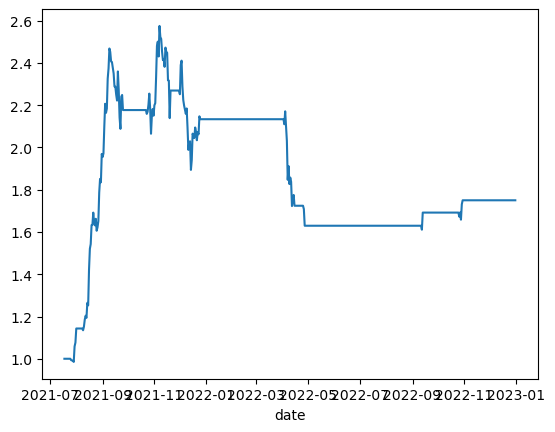

In [277]:
df_final_with_rolling_r2_sol['equity_curve'].plot()

<Axes: xlabel='date'>

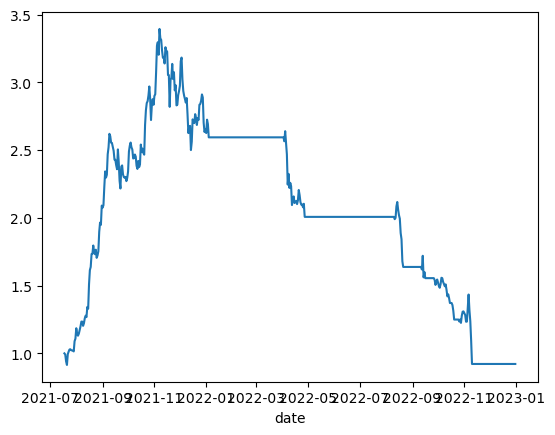

In [285]:
df_final_with_smoothing_and_stretching_act_2_atr_sol['equity_curve'].plot()

<Axes: xlabel='date'>

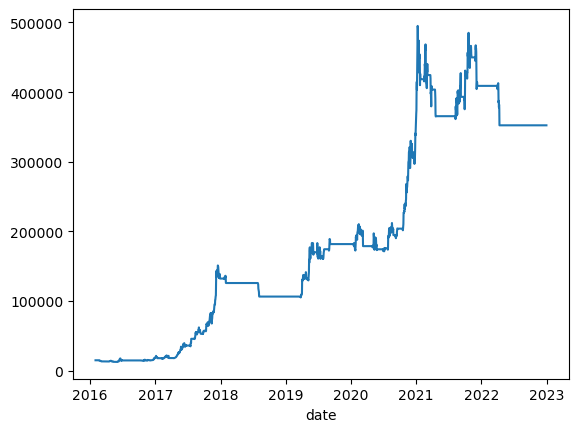

In [301]:
df_final_with_rolling_r2['total_portfolio_value'].plot()

<Axes: xlabel='date'>

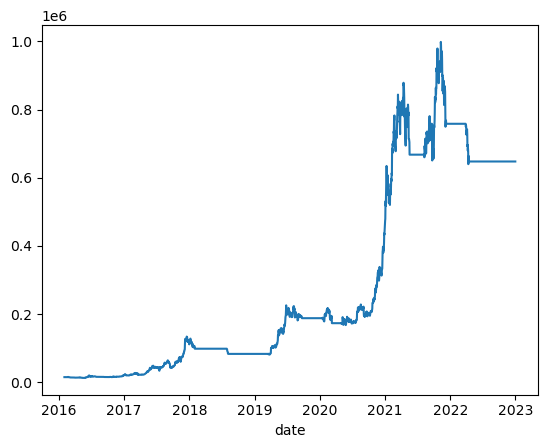

In [303]:
df_final_with_smoothing_and_stretching_act_2_atr['total_portfolio_value'].plot()

In [309]:
df_final_with_rolling_r2.columns

Index(['BTC-USD_20_avg_true_range_price', 'BTC-USD_actual_position_notional',
       'BTC-USD_actual_position_size', 'BTC-USD_annualized_volatility_20',
       'BTC-USD_cash_shrink_factor', 'BTC-USD_close',
       'BTC-USD_cooldown_counter', 'BTC-USD_event', 'BTC-USD_final_signal',
       'BTC-USD_final_weighted_additive_signal',
       'BTC-USD_new_position_entry_exit_price',
       'BTC-USD_new_position_notional', 'BTC-USD_new_position_size',
       'BTC-USD_open', 'BTC-USD_open_position_notional',
       'BTC-USD_open_position_size', 'BTC-USD_short_sale_proceeds',
       'BTC-USD_stop_loss', 'BTC-USD_stopout_flag', 'BTC-USD_t_1_close',
       'BTC-USD_t_1_close_pct_returns', 'BTC-USD_target_notional',
       'BTC-USD_target_size', 'BTC-USD_target_vol_normalized_weight',
       'BTC-USD_vol_adjusted_trend_signal', 'daily_portfolio_volatility',
       'available_cash', 'count_of_positions',
       'total_actual_position_notional', 'total_target_notional',
       'total_portfolio_value

In [311]:
df_trend['BTC-USD_rolling_r_sqr'].describe()

count    2.518000e+03
mean     4.704059e-01
std      2.988477e-01
min      8.648275e-08
25%      1.906646e-01
50%      4.965979e-01
75%      7.490857e-01
max      9.638618e-01
Name: BTC-USD_rolling_r_sqr, dtype: float64

<Axes: xlabel='date'>

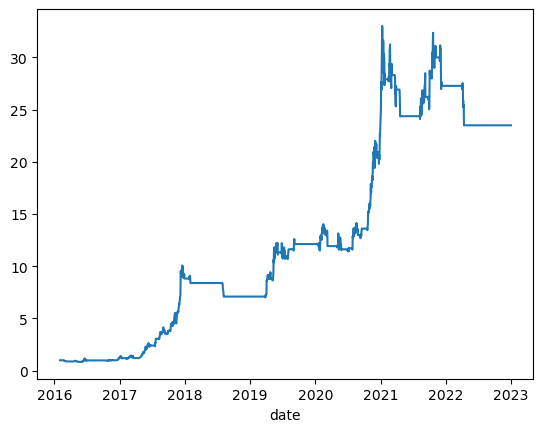

In [213]:
df_final_with_rolling_r2['equity_curve'].plot()

<Axes: xlabel='date'>

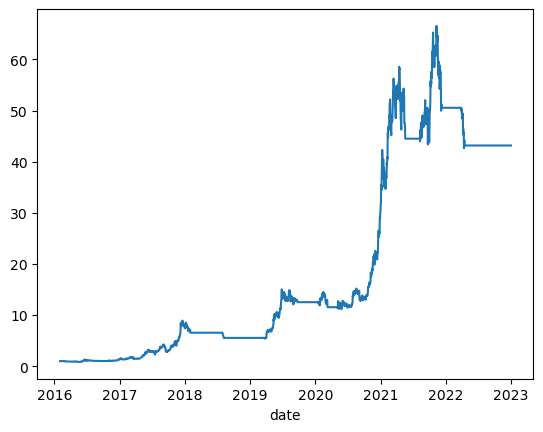

In [215]:
df_final_with_smoothing_and_stretching_act_2_atr['equity_curve'].plot()

In [207]:
df_final_with_rolling_r2.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_20,BTC-USD_cash_shrink_factor,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-01,18.219570,0.0,0.0,1.076237,0.0,371.33,0.0,0,0.0,0.0,0.00,0.0,0.0,367.89,0.0,0.0,0.0,0.0,False,367.95,-0.027770,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,0.0,1.0,1.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016-02-01,1,132 days,False
2016-02-02,17.697706,0.0,0.0,1.072386,0.0,372.93,0.0,No Position,0.0,0.0,371.33,0.0,0.0,371.33,0.0,0.0,0.0,0.0,False,371.33,0.009186,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.000000e+12,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016-02-02,1,132 days,False
2016-02-03,16.320782,0.0,0.0,1.073254,0.0,368.87,0.0,No Position,0.0,0.0,372.93,0.0,0.0,372.93,0.0,0.0,0.0,0.0,False,372.93,0.004309,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.000000e+12,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016-02-03,1,132 days,False
2016-02-04,15.469279,0.0,0.0,1.073469,0.0,387.99,0.0,No Position,0.0,0.0,368.87,0.0,0.0,368.87,0.0,0.0,0.0,0.0,False,368.87,-0.010887,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.000000e+12,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016-02-04,1,132 days,False
2016-02-05,16.080776,0.0,0.0,0.814133,0.0,384.50,0.0,No Position,0.0,0.0,387.99,0.0,0.0,387.99,0.0,0.0,0.0,0.0,False,387.99,0.051834,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.000000e+12,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016-02-05,1,132 days,False


In [193]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_final_with_smoothing_and_stretching_act_2_atr, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7230140311091127,
 'annualized_sharpe_ratio': 1.3806675417487349,
 'calmar_ratio': 1.830991289035035,
 'annualized_std_dev': 0.8422482168650917,
 'max_drawdown': -0.39487573503976303,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.28780680918448137,
 't_statistic': 3.935411578481463,
 'p_value': 8.529696488330034e-05,
 'trade_count': 423.0}

<Axes: xlabel='date'>

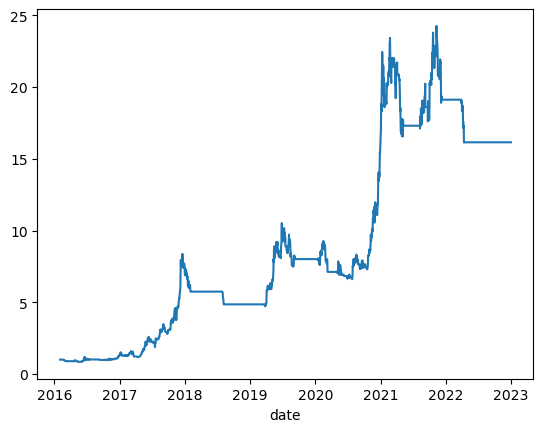

In [195]:
df_final_with_rolling_r2['equity_curve'].plot()

<Axes: xlabel='date'>

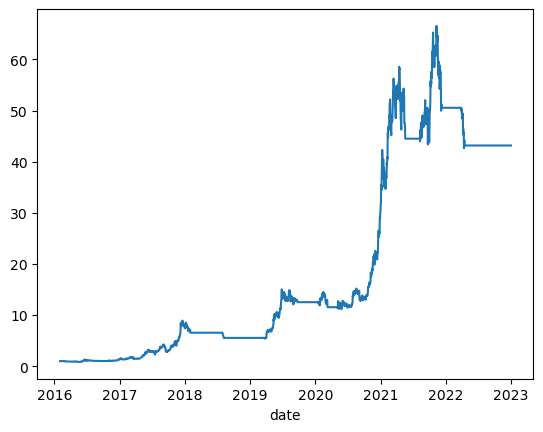

In [197]:
df_final_with_smoothing_and_stretching_act_2_atr['equity_curve'].plot()

## Out of Sample Testing

In [67]:
out_of_sample_start_date = pd.Timestamp('2023-01-01').date()
out_of_sample_end_date = pd.Timestamp('2025-05-31').date()

In [73]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
df_btc_oos_wo_regime = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=out_of_sample_start_date, end_date=out_of_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [69]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2 * ATR
## ADX Cap = 45
## ADX Floor = 15
# adx_period = 14
# adx_signal_threshold = 15
adx_period = 14
adx_signal_threshold = 15
adx_cap = 45
adx_floor = 12
df_btc_oos = apply_target_volatility_position_sizing_continuous_strategy_regime(
    start_date=out_of_sample_start_date, end_date=out_of_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
    adx_period=adx_period, adx_signal_threshold=adx_signal_threshold, adx_cap=adx_cap, adx_floor=adx_floor,long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [74]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_btc_oos_wo_regime, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.20223713509786934,
 'annualized_sharpe_ratio': 0.5893031460262718,
 'calmar_ratio': 0.9938139790913856,
 'annualized_std_dev': 0.7165277734992093,
 'max_drawdown': -0.20349596539461912,
 'max_drawdown_duration': Timedelta('307 days 00:00:00'),
 'hit_rate': 0.2596944770857814,
 't_statistic': 1.1390909609334139,
 'p_value': 0.2549861316882939,
 'trade_count': 81.0}

In [70]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_btc_oos, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='count_of_positions', annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.12660834152447453,
 'annualized_sharpe_ratio': 0.3817855890563395,
 'calmar_ratio': 0.6051616985032124,
 'annualized_std_dev': 0.7182698500016279,
 'max_drawdown': -0.20921406929358474,
 'max_drawdown_duration': Timedelta('307 days 00:00:00'),
 'hit_rate': 0.24324324324324326,
 't_statistic': 0.8261131179938133,
 'p_value': 0.40897174159620353,
 'trade_count': 79.0}